### Pre-installs

In [4]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install sklearn
# %pip install -U scikit-learn
# %pip install spotipy

### Input your data here

In [98]:
input = "22"

In [168]:
import pandas as pd
import ast

# Importing the dataset
dataset = pd.read_csv("data/tracks_with_genres.csv")
df = pd.read_csv("data/tracks.csv")

# Creating the dataframe
df_generated = pd.DataFrame(dataset)
df_generated['genres'] = df_generated['genres'].apply(ast.literal_eval)

In [100]:
# Spotify API Authentication Information
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_id = # CLIENT ID GOES HERE
client_secret = # CLIENT SECRET GOES HERE
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

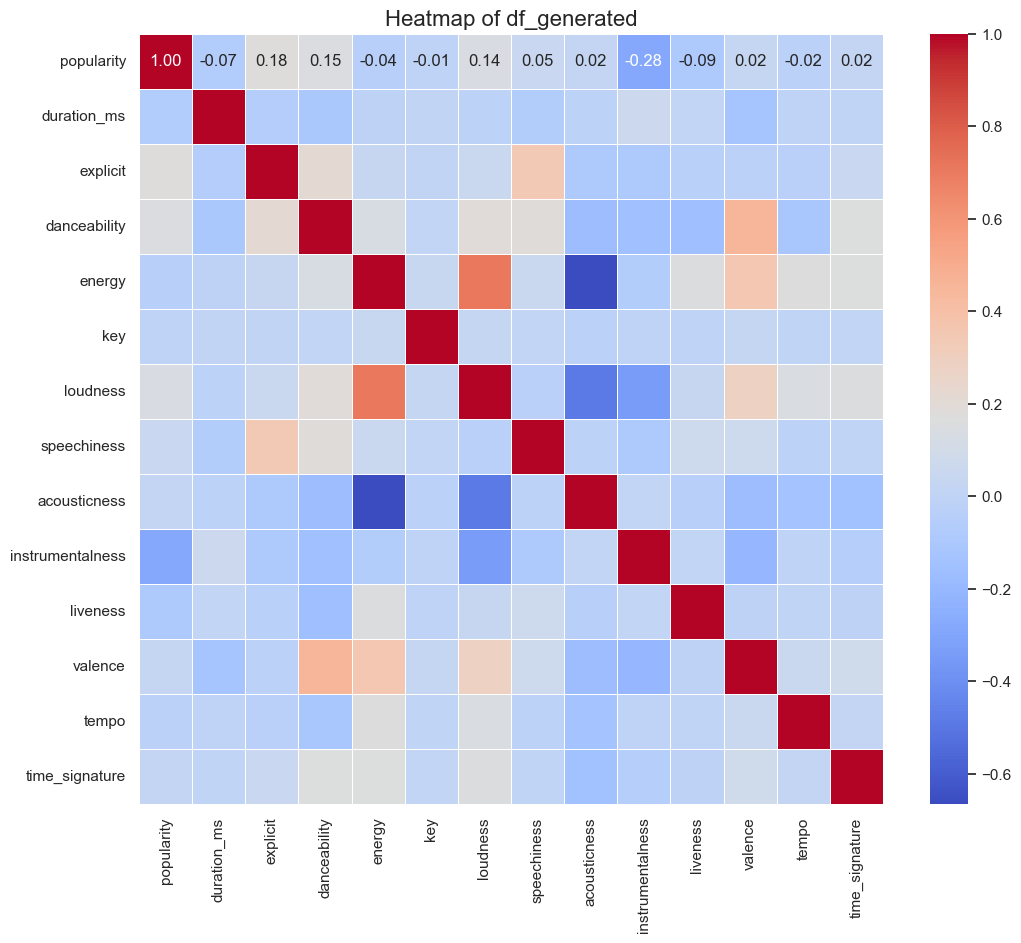

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_generated is your DataFrame
# Adjust this part based on your actual DataFrame structure
# For example, you might need to select specific columns or rows
# or convert categorical variables to numerical values for visualization

df_generated.columns
df_graph = df_generated[['popularity', 'duration_ms', 'explicit',
       'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature']]

sns.set(style="white")  # Set the style of the plot

# Create a heatmap using seaborn with annotated values for the entire correlation matrix
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
heatmap = sns.heatmap(df_graph.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Customize the appearance of the heatmap
heatmap.set_title('Heatmap of df_generated', fontsize=16)

plt.show()

### Processing the Input Song

In [101]:
# Using Spotify API to search for a song's information based on input and adding the necessary information in a DataFrame.
def search_track(track_name):
    # Search for the track
    results = sp.search(q=track_name, type='track')

    # Check if the track exists
    if results['tracks']['total'] > 0:
        # Get the first track from the results
        track = results['tracks']['items'][0]
        explicit = int(track["explicit"] == True)
        print(f'Found track: {track["name"]} by {track["artists"][0]["name"]} from the album {track["album"]["name"]}.')
        track_dict = {"id": track["id"], "name": track["name"], "popularity": track["popularity"], 
                      "duration_ms": track["duration_ms"], "explicit": explicit, "artists": track["artists"][0]["name"],
                      "id_artists": track["artists"][0]["id"], "release_date": track["album"]["release_date"]}
        return track_dict
    else:
        print('Track not found')
        return None

# Creating a Single Row DataFrame for the input song.
track_result = search_track(input)
td = pd.DataFrame(track_result, index=[0])
td

Found track: 22 (Taylor's Version) by Taylor Swift from the album Red (Taylor's Version).


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,Taylor Swift,06HL4z0CvFAxyc27GXpf02,2021-11-12


In [102]:
# Obtaining Feature Data from song based on its song_id from previous function and adding them to a DataFrame.
def get_audio_features(track_result):
    song_id = track_result["id"]
    results = sp.audio_features(song_id)

    if results:
        return results[0]
    else:
        print(f'No audio features found for song ID: {song_id}')
        return None

audio_features = get_audio_features(track_result)
af = pd.DataFrame(audio_features, index=[0])
# Taking out the irrevelant features.
af_formatted = af.drop(["type", "id", "uri", "track_href", "analysis_url", "duration_ms"], axis=1)
# Merging both DataFrames to sync up with the dataset's layout.
td = pd.concat([td, af_formatted], axis=1)
td['year'] = td['release_date'].str.extract(r'(\d{4})').astype(int)

In [10]:
td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,Taylor Swift,06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,-5.62,1,0.0281,0.000443,0.00001,0.0753,0.642,103.984,4,2021


In [103]:
import ast

td['artists'] = "['" + td['artists'] + "']"
td['artists'] = td['artists'].apply(ast.literal_eval)

td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,[Taylor Swift],06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,-5.62,1,0.0281,0.000443,0.00001,0.0753,0.642,103.984,4,2021


In [104]:
td['artists_count'] = len(td['artists'])
td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,[Taylor Swift],06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,1,0.0281,0.000443,0.00001,0.0753,0.642,103.984,4,2021,1


In [105]:
expanded_artists = td['artists'].apply(lambda x: pd.Series(x))

# Rename the columns
expanded_artists.columns = [f"artist_{i+1}" for i in range(len(expanded_artists.columns))]

# Concatenate the expanded columns with the original DataFrame
td = pd.concat([td, expanded_artists], axis=1)
td.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count,artist_1
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,[Taylor Swift],06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,0.0281,0.000443,0.00001,0.0753,0.642,103.984,4,2021,1,Taylor Swift


In [106]:
def get_artist_genres(artist_name):
    try:
        results = sp.search(q='artist:' + artist_name, type='artist')
        genres = results['artists']['items'][0]['genres']
        return genres if genres else []
    except IndexError:
        return []
    
for i in range(len(td['artists_count'])):
    td['genres'] = td['artist_' + str(i+1)].apply(get_artist_genres)

td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count,artist_1,genres
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,[Taylor Swift],06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,0.000443,0.00001,0.0753,0.642,103.984,4,2021,1,Taylor Swift,[pop]


### Adding Input to Dataset and further processing

In [107]:
# Adding the Input Song to the Dataset DataFrame. Added to the very front.
new_df = pd.concat([td, df_generated], ignore_index=True)
new_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,tempo,time_signature,year,artists_count,artist_1,genres,song_name_artist,artist_2,artist_3,artist_4
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,[Taylor Swift],06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,103.984,4,2021,1,Taylor Swift,[pop],NaN,NaN,NaN,NaN
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,...,113.564,3,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",You'll Never Walk Alone - Mono; 2002 Remaster[...,NaN,NaN,NaN
2,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,120.689,4,2020,1,The Toys,[],A Lover's Concerto['The Toys'],NaN,NaN,NaN
3,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,120.689,4,2020,1,The Toys,[thai pop],A Lover's Concerto['The Toys'],NaN,NaN,NaN
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,...,104.536,4,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Ferry Cross the Mersey - Mono; 2002 Remaster['...,NaN,NaN,NaN


In [108]:
new_df['song_id_name'] = new_df['id'] + new_df['name']
print(new_df.shape)
new_df.drop_duplicates(subset=["song_id_name"], keep='first', inplace=True)
print(new_df.shape)

(228030, 29)
(186012, 29)


In [109]:
def count_items_in_list(lst):
    return len(lst)

# Apply the function to the DataFrame column
new_df['genres_count'] = new_df['genres'].apply(count_items_in_list)
new_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,year,artists_count,artist_1,genres,song_name_artist,artist_2,artist_3,artist_4,song_id_name,genres_count
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,[Taylor Swift],06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,2021,1,Taylor Swift,[pop],NaN,NaN,NaN,NaN,3yII7UwgLF6K5zW3xad3MP22 (Taylor's Version),1
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",You'll Never Walk Alone - Mono; 2002 Remaster[...,NaN,NaN,NaN,6catF1lDhNTjjGa2GxRQNNYou'll Never Walk Alone ...,9
2,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,2020,1,The Toys,[],A Lover's Concerto['The Toys'],NaN,NaN,NaN,6Pkt6qVikqPBt9bEQy8iTzA Lover's Concerto,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Ferry Cross the Mersey - Mono; 2002 Remaster['...,NaN,NaN,NaN,4aSw1QJIMwYSoDEgzgdCJLFerry Cross the Mersey -...,9
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,34,157093,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.477,0.352,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Don't Let the Sun Catch You Crying (Main) - Mo...,NaN,NaN,NaN,0ZMMtH875IR2TfkyC4PolDDon't Let the Sun Catch ...,9


In [114]:
print(new_df.shape)
new_df = new_df[(new_df['genres_count'] != 0)]
print(new_df.shape)

(186012, 30)
(166252, 30)


### Supersetting genres

In [115]:
genre_extract = new_df['genres'].reset_index()
genre_wo_index = genre_extract['genres']
tally = genre_wo_index.count()
genre_dict = {}

for i in range (tally):
    input = genre_wo_index.loc[i]
    if len(input) > 0:
        for n in input:
            if n in genre_dict.keys():
                genre_dict[n] += 1
            else:
                genre_dict[n] = 1

print(genre_dict)

{'pop': 6881, 'folk rock': 933, 'british invasion': 495, 'merseybeat': 529, 'rock-and-roll': 650, 'rockabilly': 550, 'classic uk pop': 704, 'adult standards': 1216, 'bubblegum pop': 416, 'brill building pop': 763, 'lounge': 283, 'easy listening': 126, 'canadian blues': 54, 'british blues': 265, 'mellow gold': 1141, 'lilith': 307, 'singer-songwriter': 312, 'canadian singer-songwriter': 107, 'folk': 393, 'rock': 3193, 'harlem renaissance': 23, 'big band': 94, 'stride': 75, 'cool jazz': 274, 'jazz': 304, 'swing': 56, 'jazz piano': 73, 'vocal jazz': 355, 'contemporary jazz': 73, 'jazz saxophone': 71, 'swedish jazz': 134, 'jazz quartet': 20, 'avant-garde jazz': 49, 'contemporary post-bop': 57, 'italian jazz': 15, 'jazz fusion': 297, 'free jazz': 58, 'classic soundtrack': 89, 'italian soundtrack': 28, 'vintage italian soundtrack': 34, 'soundtrack': 456, 'hard bop': 204, 'jazz trumpet': 176, 'psychedelic rock': 592, 'roots rock': 250, 'acid rock': 67, 'classic rock': 1358, 'hard rock': 728, '

Counter({1: 438, 2: 279, 3: 199, 4: 175, 6: 120, 5: 117, 8: 85, 9: 84, 7: 82, 10: 69, 12: 64, 13: 60, 11: 55, 14: 55, 15: 53, 18: 50, 16: 49, 19: 47, 17: 41, 22: 40, 20: 39, 23: 38, 26: 34, 28: 29, 21: 29, 34: 28, 27: 28, 36: 25, 51: 25, 29: 24, 30: 22, 35: 22, 25: 22, 31: 21, 37: 21, 32: 21, 38: 20, 41: 20, 33: 20, 24: 20, 43: 19, 57: 17, 40: 17, 39: 17, 46: 17, 47: 17, 42: 17, 53: 16, 54: 15, 67: 15, 49: 14, 63: 14, 55: 14, 48: 13, 120: 13, 60: 13, 73: 12, 58: 12, 50: 12, 52: 12, 45: 12, 56: 11, 44: 11, 80: 11, 78: 11, 69: 11, 81: 10, 87: 10, 77: 10, 71: 9, 95: 9, 104: 9, 59: 9, 118: 9, 83: 9, 74: 9, 90: 9, 76: 9, 68: 9, 75: 8, 89: 8, 65: 8, 72: 8, 66: 8, 82: 8, 100: 8, 110: 8, 98: 8, 114: 7, 173: 7, 113: 7, 105: 7, 70: 7, 92: 7, 112: 7, 64: 7, 79: 7, 93: 7, 111: 7, 103: 7, 94: 6, 134: 6, 225: 6, 85: 6, 143: 6, 130: 6, 101: 6, 224: 6, 106: 6, 108: 6, 88: 6, 99: 6, 126: 5, 196: 5, 229: 5, 256: 5, 86: 5, 61: 5, 150: 5, 152: 5, 125: 5, 136: 5, 188: 5, 180: 5, 163: 5, 122: 5, 91: 5, 97: 

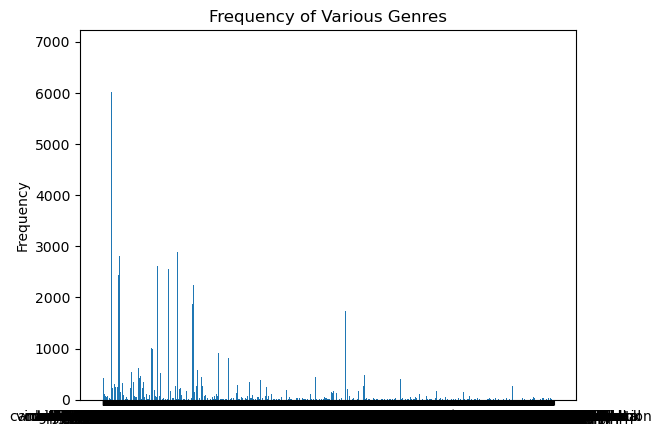

In [59]:
import matplotlib.pyplot as plt

# Plot the frequency distribution
plt.bar(genre_dict.keys(), genre_dict.values())
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency of Various Genres')
plt.show()

In [120]:
genres_df = pd.Series(genre_dict)
genres_df.head()

pop                 6881
folk rock            933
british invasion     495
merseybeat           529
rock-and-roll        650
dtype: int64

In [121]:
genres_df.T.describe()

count    4229.000000
mean      130.132419
std       393.314261
min         1.000000
25%         4.000000
50%        19.000000
75%        85.000000
max      6881.000000
dtype: float64

In [68]:
genres_df.to_csv("data/genre_frequency.csv")

In [122]:
from collections import defaultdict

def group_into_supersets(genre_dict):
    supersets = defaultdict(int)

    for genre, frequency in genre_dict.items():
        matched = False
        for superset in supersets:
            if any(subset in genre for subset in superset.split()):
                supersets[superset] += frequency
                matched = True
                break
        if not matched:
            supersets[genre] += frequency

    return supersets

# Group into supersets
supersets = group_into_supersets(genre_dict)

# Output the result
for superset, frequency in supersets.items():
    print(f"{superset}: {frequency}")

pop: 155914
folk rock: 71191
british invasion: 1309
merseybeat: 529
adult standards: 1219
lounge: 343
easy listening: 144
canadian blues: 2559
mellow gold: 2277
lilith: 307
singer-songwriter: 3374
harlem renaissance: 46
big band: 3086
stride: 75
cool jazz: 5527
swing: 697
contemporary post-bop: 2990
classic soundtrack: 6485
hard bop: 2218
motown: 177
soul: 3119
beatlesque: 95
cabaret: 175
freakbeat: 40
protopunk: 50
oklahoma country: 3036
experimental: 200
late romantic era: 5140
orchestral performance: 575
french orchestra: 3984
compositional ambient: 435
funk: 2928
nashville sound: 397
permanent wave: 1901
alternative metal: 18651
post-grunge: 615
rap: 27574
detroit hip hop: 35776
ancient mediterranean: 653
reggae fusion: 8773
hyphy: 65
wrestling: 113
eurodance: 745
zolo: 34
post-punk: 299
miami indie: 12110
industrial techno: 1375
minimal dub: 377
brostep: 166
bassline: 72
edm: 5123
electro house: 15765
old school dancehall: 1286
ragga jungle: 206
ska: 1628
regional mexican: 3925
no

In [123]:
print(len(supersets.keys()))

359


In [156]:
def generate_superset_mapping(genre_dict):
    superset_mapping = {}

    for genre, frequency in genre_dict.items():
        superset_found = False
        for superset in superset_mapping:
            if any(subset in genre for subset in superset_mapping[superset]):
                superset_mapping[superset].append(genre)
                superset_found = True
                break
        if not superset_found:
            superset_mapping[genre] = [genre]

    return superset_mapping

# Generate superset mapping
superset_mapping = generate_superset_mapping(genre_dict)

# Output the superset mapping
for superset, subsets in superset_mapping.items():
    print(f"{superset}: {subsets}")

pop: ['pop', 'classic uk pop', 'bubblegum pop', 'brill building pop', 'sunshine pop', 'baroque pop', 'dance pop', 'pop rock', 'post-teen pop', 'pop rap', 'new wave pop', 'finnish pop', 'finnish dance pop', 'uk pop punk', 'europop', 'canadian pop', 'barbadian pop', 'latin pop', 'acoustic pop', 'spanish pop rock', 'mexican pop', 'latin arena pop', 'spanish pop', 'bow pop', 'pop nacional', 'socal pop punk', 'britpop', 'sophisti-pop', 'hip pop', 'south african pop', 'south african pop dance', 'bahamian pop', 'puerto rican pop', 'canadian pop punk', 'power-pop punk', 'deep power-pop punk', 'antiviral pop', 'j-pop girl group', 'australian pop', 'art pop', 'indie pop', 'pop punk', 'synthpop', 'norwegian pop', 'candy pop', 'ambient pop', 'glitch pop', 'french pop', 'dream pop', 'italian adult pop', 'indonesian pop', 'electropop', 'german pop rock', 'german pop', 'tatar pop', 'collage pop', 'pop r&b', 'belarusian pop', 'pop rock brasileiro', 'c-pop', 'cantopop', 'mandopop', 'classic mandopop', 

In [148]:
import pandas as pd

genres_df = pd.DataFrame(genres_df, columns=['genres'])

def group_into_supersets(new_df, superset_mapping):
    def get_superset(genres):
        for superset, subsets in superset_mapping.items():
            if any(subset in genre for genre in genres for subset in subsets):
                return superset
        return 'other'  # If no superset is found

    new_df['supersetted_genres'] = new_df['genres'].apply(get_superset)
    return new_df

# Group into supersets and create new column
new_df = group_into_supersets(new_df, superset_mapping)

In [149]:
new_df['supersetted_genres'].value_counts().count()

889

### Encoding

In [150]:
genres_dummies = pd.get_dummies(new_df['supersetted_genres'].apply(pd.Series).stack()).groupby(level=0).sum()

# Concatenate the binary columns with the original DataFrame
df_2 = pd.concat([new_df, genres_dummies], axis=1)

In [151]:
df_2 = df_2.drop(['id_artists', 'release_date', 'popularity', 'mode', 'artists_count', 'song_name_artist', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'genres', 'supersetted_genres'], axis=1)
df_2.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,yoga,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),230960,0,[Taylor Swift],0.642,0.695,7,-5.620,0.0281,...,0,0,0,0,0,0,0,0,0,0
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,160187,0,NaN,0.484,0.265,0,-11.101,0.0322,...,0,0,0,0,0,0,0,0,0,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,141987,0,NaN,0.405,0.365,6,-10.226,0.0289,...,0,0,0,0,0,0,0,0,0,0
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,157093,0,NaN,0.477,0.352,1,-14.165,0.0300,...,0,0,0,0,0,0,0,0,0,0
6,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,187333,0,NaN,0.319,0.201,7,-17.796,0.0623,...,0,0,0,0,0,0,0,0,0,0


In [152]:
df_2 = df_2.fillna(0)
df_2.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,yoga,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),230960,0,[Taylor Swift],0.642,0.695,7,-5.620,0.0281,...,0,0,0,0,0,0,0,0,0,0
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,160187,0,0,0.484,0.265,0,-11.101,0.0322,...,0,0,0,0,0,0,0,0,0,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,141987,0,0,0.405,0.365,6,-10.226,0.0289,...,0,0,0,0,0,0,0,0,0,0
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,157093,0,0,0.477,0.352,1,-14.165,0.0300,...,0,0,0,0,0,0,0,0,0,0
6,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,187333,0,0,0.319,0.201,7,-17.796,0.0623,...,0,0,0,0,0,0,0,0,0,0


In [155]:
df_2.shape

(166252, 907)

### Cosine Similarity & Output Extraction

In [157]:
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# Feature selection, removing non-useful rows.
def processing(df_2):
    # Normalize numerical features
    numerical_features = ['duration_ms', 'loudness', 'tempo']
    scaler = MinMaxScaler()
    df_2[numerical_features] = scaler.fit_transform(df_2[numerical_features])
    
    # Standardize Year
    df_2['standardized_year'] = scaler.fit_transform(df_2[['year']])
    df_2 = df_2.drop(['year'], axis=1)

    # Create a feature matrix
    feature_matrix = df_2.drop(['id', 'name', 'artists', 'song_id_name', 'explicit', 'time_signature'], axis=1)

    # Apply normalization to the entire feature matrix
    feature_matrix = scaler.fit_transform(feature_matrix)

    # This is the input song. We are isolating it from the dataframe first.
    input_song = feature_matrix[0]
    
    arr = []

    # Returns comparison value of first song in dataset to all others in an array.
    # DataFrame can be customized before Feature Selection to change which song the subject of comparison should be.
    for i in range(1, len(feature_matrix)):
        # Take the i-th song from the feature matrix
        compare_song = feature_matrix[i]
        # Perform cosine similarity.
        cosine_sim = cosine_similarity([input_song], [compare_song])
        cs_value = cosine_sim[0][0]  # Take the single similarity value between the input song and the i-th song.
        arr.append(cs_value)

    return arr

arr = processing(df_2)
arr

[0.8588803723852401,
 0.9393863507872707,
 0.893022575596839,
 0.568245306841884,
 0.5490065360347698,
 0.9293784138089715,
 0.9201040175639994,
 0.8300806652863566,
 0.9058234016245548,
 0.9262945100897455,
 0.8780938505419276,
 0.8474136995978343,
 0.9117311483345452,
 0.5029923651008864,
 0.6482805074885927,
 0.591467846388249,
 0.6334312721286671,
 0.6769916584162683,
 0.6037161356874345,
 0.6356118098139056,
 0.6221503419788559,
 0.9404130405579503,
 0.9307721808127838,
 0.6368889793637438,
 0.8811510870577436,
 0.6379088578734466,
 0.5793405937645671,
 0.48712383522307434,
 0.5560220594286782,
 0.4781806525546222,
 0.5473685052583277,
 0.6869280427847143,
 0.8851428930338425,
 0.6094307183937462,
 0.9361949114241028,
 0.6709639348460059,
 0.7047056454969239,
 0.8484604143378895,
 0.892524164302579,
 0.91620418529114,
 0.9497258257075477,
 0.8881527310388637,
 0.7738618172023184,
 0.6861349384972658,
 0.7259423283386641,
 0.884474166867326,
 0.8944408725894619,
 0.9193870629424339

In [158]:
max(arr[1:])

0.9990212485082605

In [163]:
def compile_suggestions(arr):
    suggestions = []
    
    # Compiling all song ids that are above the pre-determined threshold for 'like the first song'.
    for i in range(len(arr)):
        if arr[i] > 0.995:
            suggestions.append(i)
    
    print(suggestions)
    return suggestions
suggestions = compile_suggestions(arr)

[13990, 14465, 14500, 14841, 15290, 15378, 15860, 16784, 16815, 20984, 21298, 21902, 21905, 22258, 28511, 28516, 28603, 28726, 29026, 33105, 33108, 33361, 33431, 33438, 33457, 33572, 33703, 33715, 40902, 41105, 41296, 41370, 46617, 46622, 51606, 56654, 57964, 62677, 62735, 62753, 64621, 64952, 68316, 68469, 70048, 70055, 72593, 72666, 73042, 75386, 75681, 75715, 79554, 79580, 79744, 79866, 82079, 82216, 85147, 85239, 93535, 93555, 96374, 96630, 99816, 100179, 104180, 104290, 106591, 109646, 109908, 109922, 109924, 111937, 125089, 125103, 125147, 125223, 125273, 127581, 127599, 134692, 134726, 136214, 136235, 138354, 141031, 141073, 146708, 148415, 150490, 151483, 151520, 151553, 157959, 158059, 158182, 158338, 158385, 158388, 158486, 158534, 158537, 158798, 160851, 161104, 161218, 165261, 165740, 165865]


In [164]:
len(suggestions)

110

In [165]:
# Extracting out the end result information.
df_main = df_2[df_2.index.isin(suggestions)]

df_main.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk,standardized_year
13990,4RI9eX7jNcdaQOJifn7t6z,Pound Cake / Paris Morton Music 2,0.085942,1,0,0.521,0.762,2,0.847265,0.5290,...,0,0,0,0,0,0,0,0,0,0.619048
14500,2Bs4jQEGMycglOfWPBqrVG,Steal My Girl,0.044727,0,0,0.536,0.768,10,0.859961,0.0347,...,0,0,0,0,0,0,0,0,0,0.666667
15290,10nqz67NQWWa7XPq7ycihi,Welcome To New York,0.041615,0,0,0.793,0.634,7,0.878114,0.0324,...,0,0,0,0,0,0,0,0,0,0.666667
15378,4W38RXuQNuoTSwVsQA1OGC,Nothin' Like You,0.036335,0,0,0.589,0.704,4,0.878671,0.0303,...,0,0,0,0,0,0,0,0,0,0.666667
15860,7i9763l5SSfOnqZ35VOcfy,Heavydirtysoul,0.046066,0,0,0.613,0.873,7,0.853152,0.0449,...,0,0,0,0,0,0,0,0,0,0.714286


In [166]:
df_main.count() # There is one less for the last 3 features as the input song did not go through the extracted year's steps.
# df_final['standardized_year'].describe()

id                   79
name                 79
duration_ms          79
explicit             79
artists              79
                     ..
zim urban groove     79
zolo                 79
zouglou              79
zouk                 79
standardized_year    79
Length: 908, dtype: int64

In [169]:
df_main = df_main.iloc[1:]

df_main = df_main.drop('artists', axis=1)

id_artist_mapping = df.set_index('id')['artists'].to_dict()

# Add 'artist' column to df1 using the mapping
df_main['artists'] = df_main['id'].map(id_artist_mapping)
df_main.head()

,id,name,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,...,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk,standardized_year,artists
15290,10nqz67NQWWa7XPq7ycihi,Welcome To New York,0.041615,0,0.793,0.634,7,0.878114,0.0324,0.038000,...,0,0,0,0,0,0,0,0,0.666667,['Taylor Swift']
15378,4W38RXuQNuoTSwVsQA1OGC,Nothin' Like You,0.036335,0,0.589,0.704,4,0.878671,0.0303,0.151000,...,0,0,0,0,0,0,0,0,0.666667,['Dan + Shay']
15860,7i9763l5SSfOnqZ35VOcfy,Heavydirtysoul,0.046066,0,0.613,0.873,7,0.853152,0.0449,0.003970,...,0,0,0,0,0,0,0,0,0.714286,['Twenty One Pilots']
16784,7F7kL3i6SDEIbDcoJZGiig,Sígueme Y Te Sigo,0.041051,0,0.736,0.878,1,0.897254,0.0428,0.069000,...,0,0,0,0,0,0,0,0,0.714286,['Daddy Yankee']
16815,1JiEXgICK7aTLAa1iRgjLC,Magic Light (Mix Cut) - Original Mix,0.021271,0,0.459,0.963,7,0.827935,0.0423,0.000008,...,0,0,0,0,0,0,0,0,0.714286,"['STANDERWICK', 'Philippe El Sisi', 'Ana Criado']"


### Recommendations Output

In [170]:
import random

# Generating 10 of the matched songs at random.
def recommend(df_main):
    print('Here are your recommendations!')
    for c in range(10):
        recc = df_main.sample().to_dict()
        name = list(recc['name'].values())[0]
        artists = (list(recc['artists'].values())[0])[1:len(list(recc['artists'].values())[0])-1]
        year = str(list(recc['year'].values())[0])
        print(str(c + 1) + '. ' + name + ' by ' + artists + ' published in ' + year)
        df_main = df_main.drop(list(recc['id'])[0])
    
# May want to try a filter for repreventing duplicate songs in the list.
recommend(df_main) # End Product

Here are your recommendations!
1. La Marcha Tropical by 'Campo' published in 2012
2. Change - Edit by 'Lisa Stansfield' published in 2003
3. Fir-Ai Tu Să Fii De Murg! by 'Liviu Vasilica' published in 2000
4. Supradin by 'Cemiyette Pişiyorum' published in 2011
5. Holandska by 'Horkýže Slíže' published in 2003
6. Not Coming Home by 'Maroon 5' published in 2002
7. Nothin' Like You by 'Dan + Shay' published in 2014
8. Move It by 'Sunset Sweatshop' published in 2018
9. Colgate Soulmate by 'Paleface' published in 2003
10. Naticongo by 'Natiruts' published in 2002
